<a href="https://colab.research.google.com/github/AmonTonui/Final_Year_Project/blob/main/MergedEducation_PeopleperroomSom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  # Install Intrasom
  !pip install minisom

LOCAL_DEV = True
if LOCAL_DEV:
    sys.path.insert(0, '../')
    %load_ext autoreload

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.5-py3-none-any.whl size=12031 sha256=87fe6d45e2815db7868b30843fd53080cadd85e45891d5311a4e690a26984d74
  Stored in directory: /root/.cache/pip/wheels/19/db/95/5e53bc2b88a328217fdf9f2886cafbe86b0df274f4b601f572
Successfully built minisom


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from minisom import MiniSom
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import numpy as np
from sklearn.model_selection import train_test_split


data = pd.read_csv("mergednormalized_with_winners_cleaned2024.csv")

filtered_data = data[data['Winning Party'].isin(['Labour', 'Conservative', 'Liberal Democrat'])]#Filtering the data to train and display conservative and labour
filtered_data = filtered_data.reset_index(drop=True)
party_colors = {
    'Conservative': (0, 0, 1),    # Blue
    'Labour': (1, 0, 0),          # Red
    'Liberal Democrat': (0.98, 0.6, 0.1),  # Orange
    # 'Green': (0, 0.6, 0.3),         # Dark Green
    # 'The Brexit Party': (0.6, 0.2, 0.8) #light blue
    # 'Reform UK': (0, 0, 0.5), # Dark Blue

}


#Data with Labels that I will use to map the result clusters
labeling_columns = ['Westminster Parliamentary constituencies', 'Winning Party', 'Winning Vote Share']
features = filtered_data.drop(columns=labeling_columns)

#Feature Scaling
# scaler = MinMaxScaler()
# normalized_features = scaler.fit_transform(data[features])

robust_scaler = RobustScaler()#Robust scaler used as it handles outliers better than min max scaler
normalized_features = robust_scaler.fit_transform(features)



normalized_df = pd.DataFrame(normalized_features, columns=features.columns)
normalized_df[labeling_columns] = filtered_data[labeling_columns]

print(normalized_df.head())
print(normalized_df.shape[0])
print(normalized_df.isnull().sum())

   Over 0.5 and up to 1.0 people per room - Level 1 and entry level qualifications: 1 to 4 GCSEs grade A* to C, Any GCSEs at other grades, O levels or CSEs (any grades), 1 AS level, NVQ level 1, Foundation GNVQ, Basic or Essential Skills  \
0                                           1.067411                                                                                                                                                                                            
1                                           0.340739                                                                                                                                                                                            
2                                          -1.147718                                                                                                                                                                                            
3                                   

In [9]:

# Initialize and Train SOM
n_neurons = int(np.sqrt(5 * np.sqrt(normalized_features.shape[0])))# thumb rule for the number of nuerons within a dataset
# n_neurons = int(math.ceil(5*np.sqrt(normalized_features.shape[0])))
m_neurons = n_neurons

som = MiniSom(n_neurons, m_neurons, normalized_features.shape[1], sigma=0.997, learning_rate=0.252,
              neighborhood_function='gaussian', random_seed=0, topology='rectangular')


som.random_weights_init(normalized_features)#Used random so that everything within the dataset may not be suppressed unlike pca makes the dataset to be linear.

# Train the SOM
num_iterations = 7000#optimal number of iterations based on the iterations tuning.
som.train(normalized_features, num_iterations, verbose=True)

# Assign winning neurons (Best Matching Units - BMUs) for each data point
winning_neurons = [som.winner(x) for x in normalized_features]
normalized_df['Neuron Row'] = [wn[0] for wn in winning_neurons]
normalized_df['Neuron Col'] = [wn[1] for wn in winning_neurons]





 [ 7000 / 7000 ] 100% - 0:00:00 left 
 quantization error: 1.1453218933615996


In [10]:
def topographic_error(som, data):
    error_count = 0
    for x in data:
        bmu = som.winner(x)
        distances = np.linalg.norm(som.get_weights() - x, axis=2)
        second_bmu = np.unravel_index(np.argsort(distances.ravel())[1], distances.shape)

        if abs(bmu[0] - second_bmu[0]) > 1 or abs(bmu[1] - second_bmu[1]) > 1:
            error_count += 1
    return error_count / len(data)

te = topographic_error(som, normalized_features)
print(f"Topographic Error: {te}")

Topographic Error: 0.2727272727272727


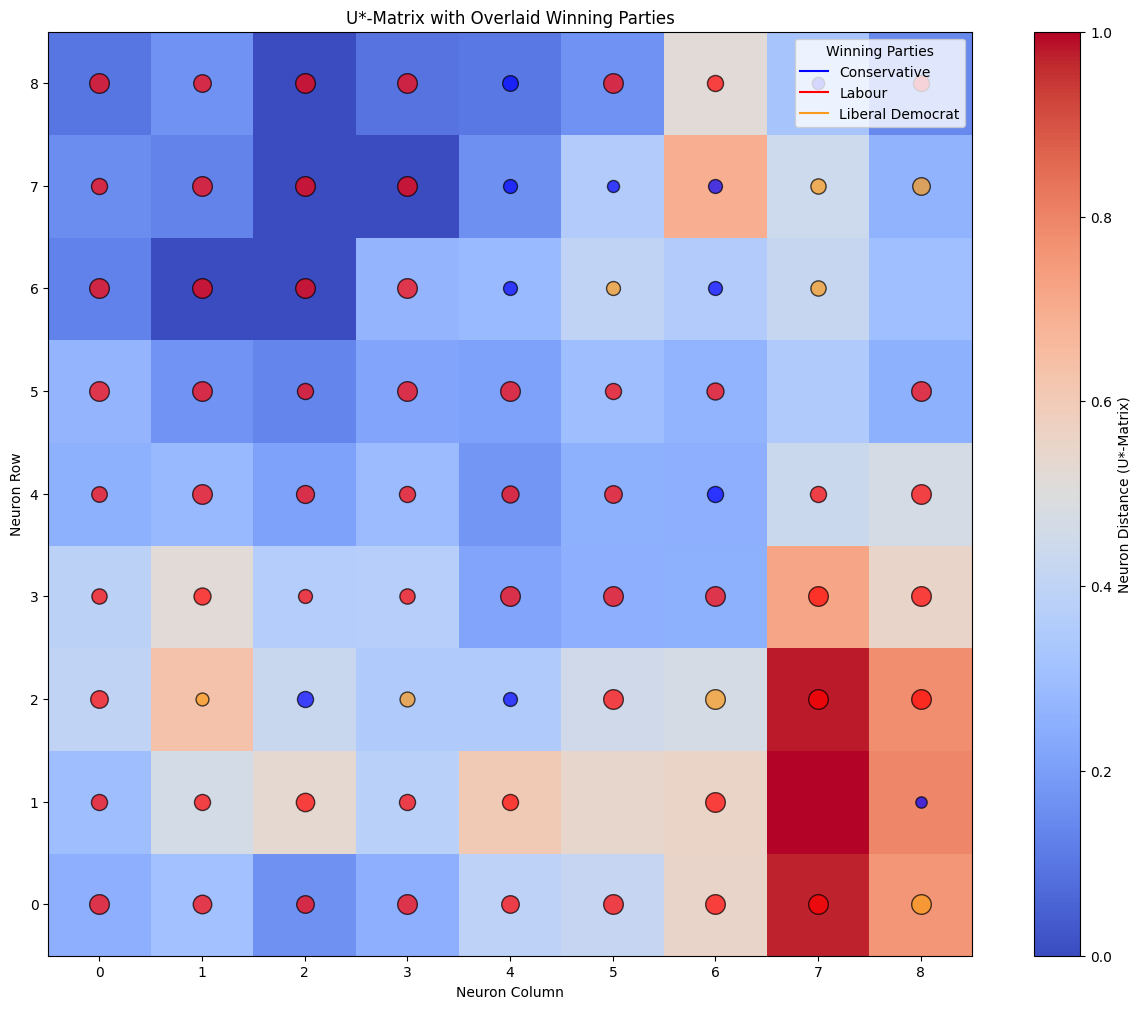

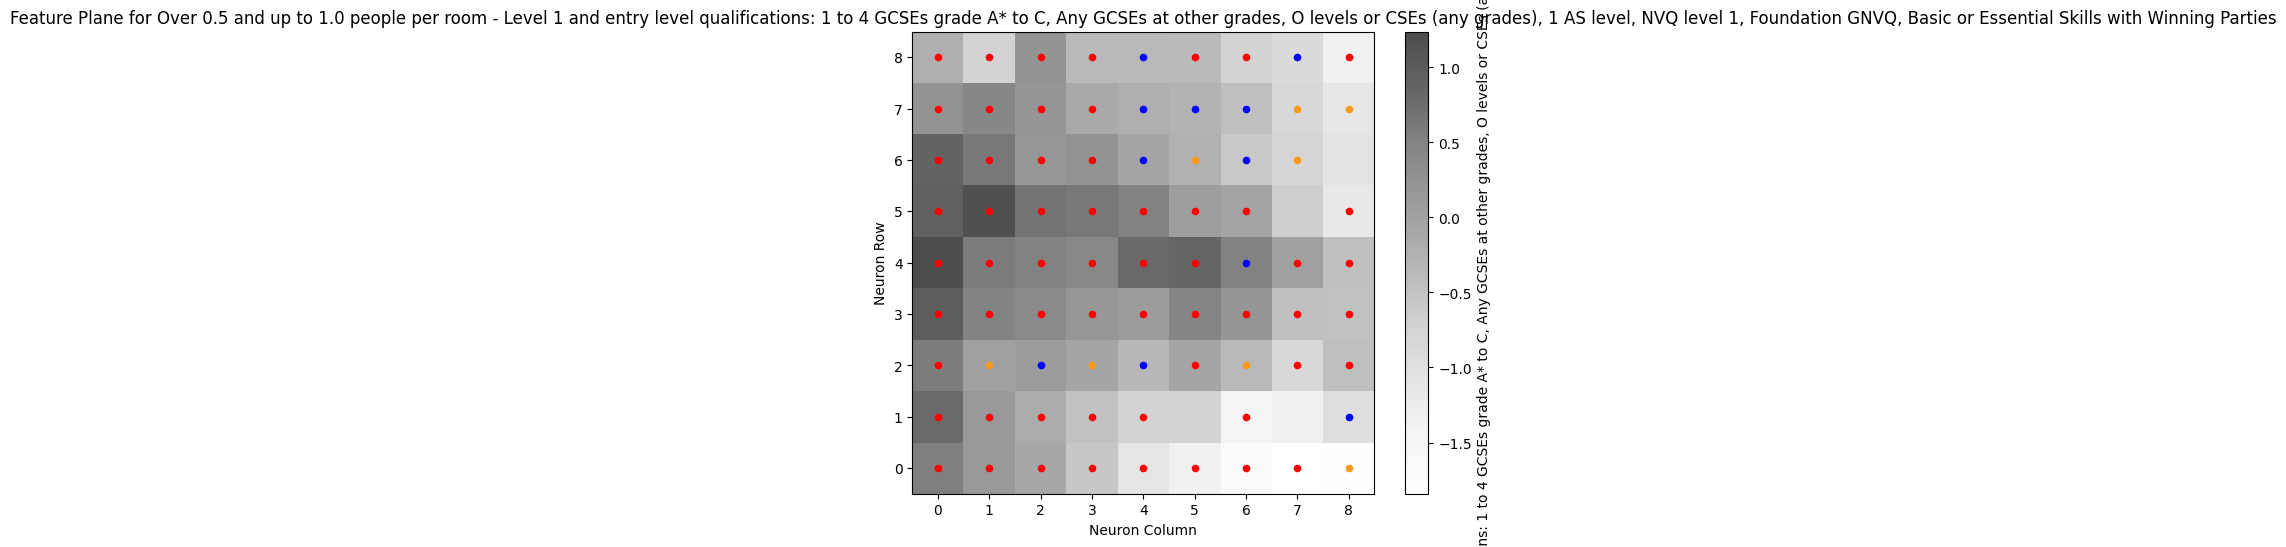

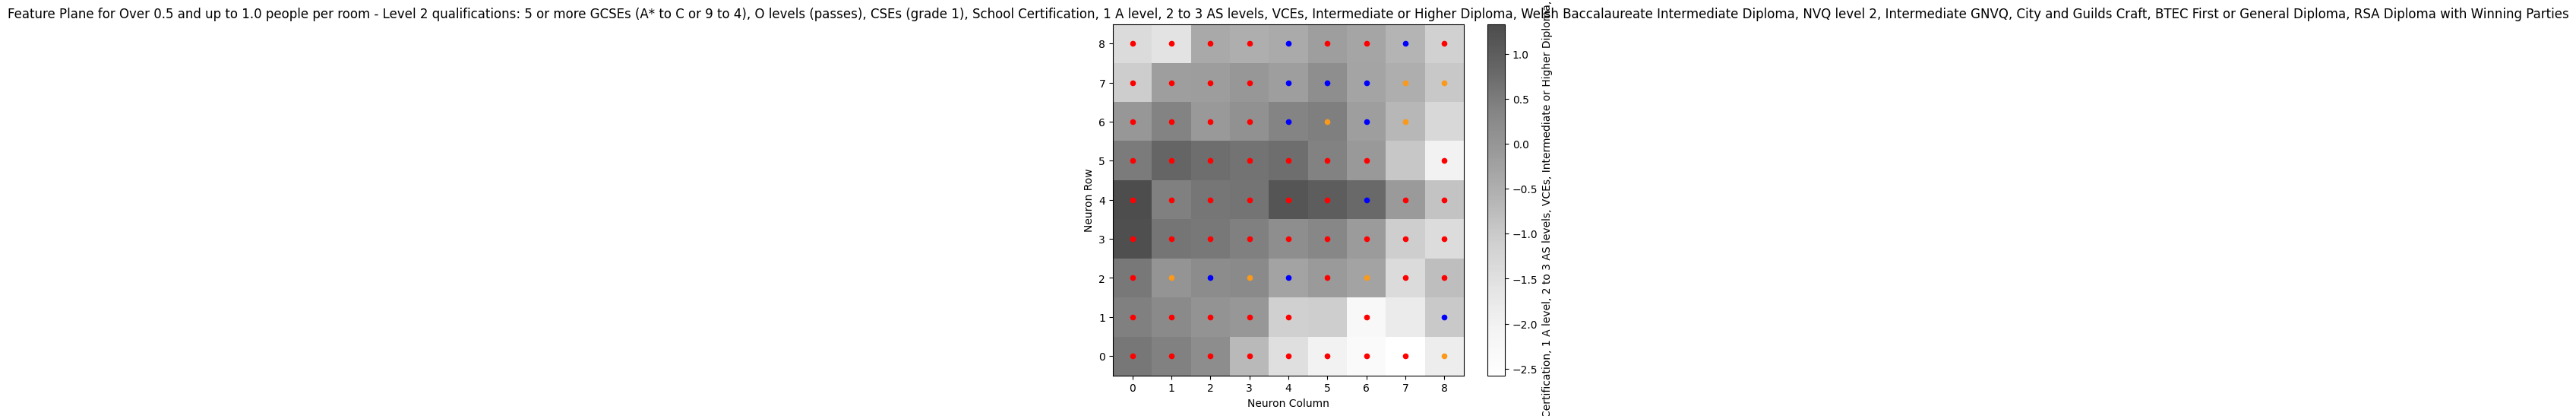

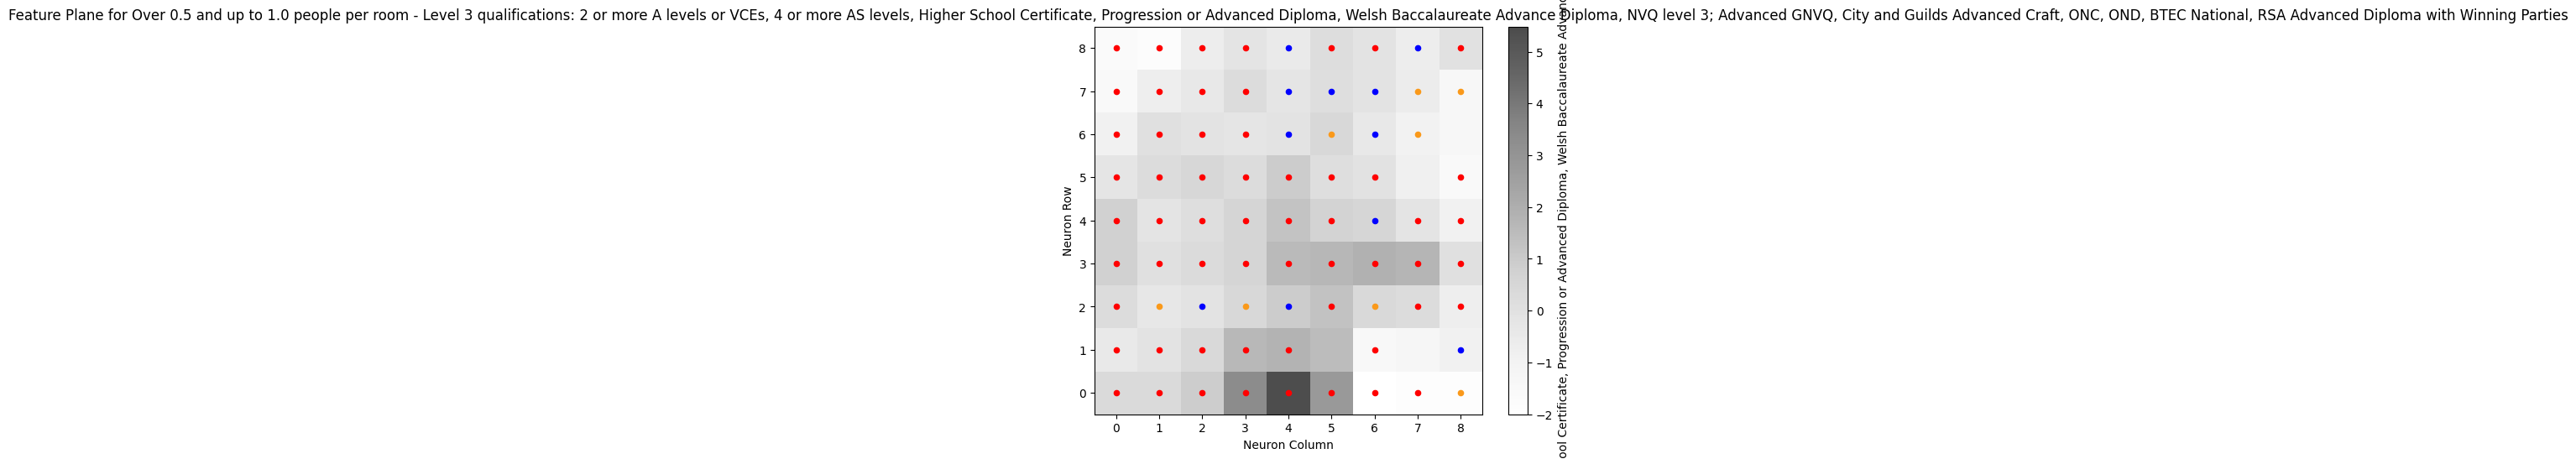

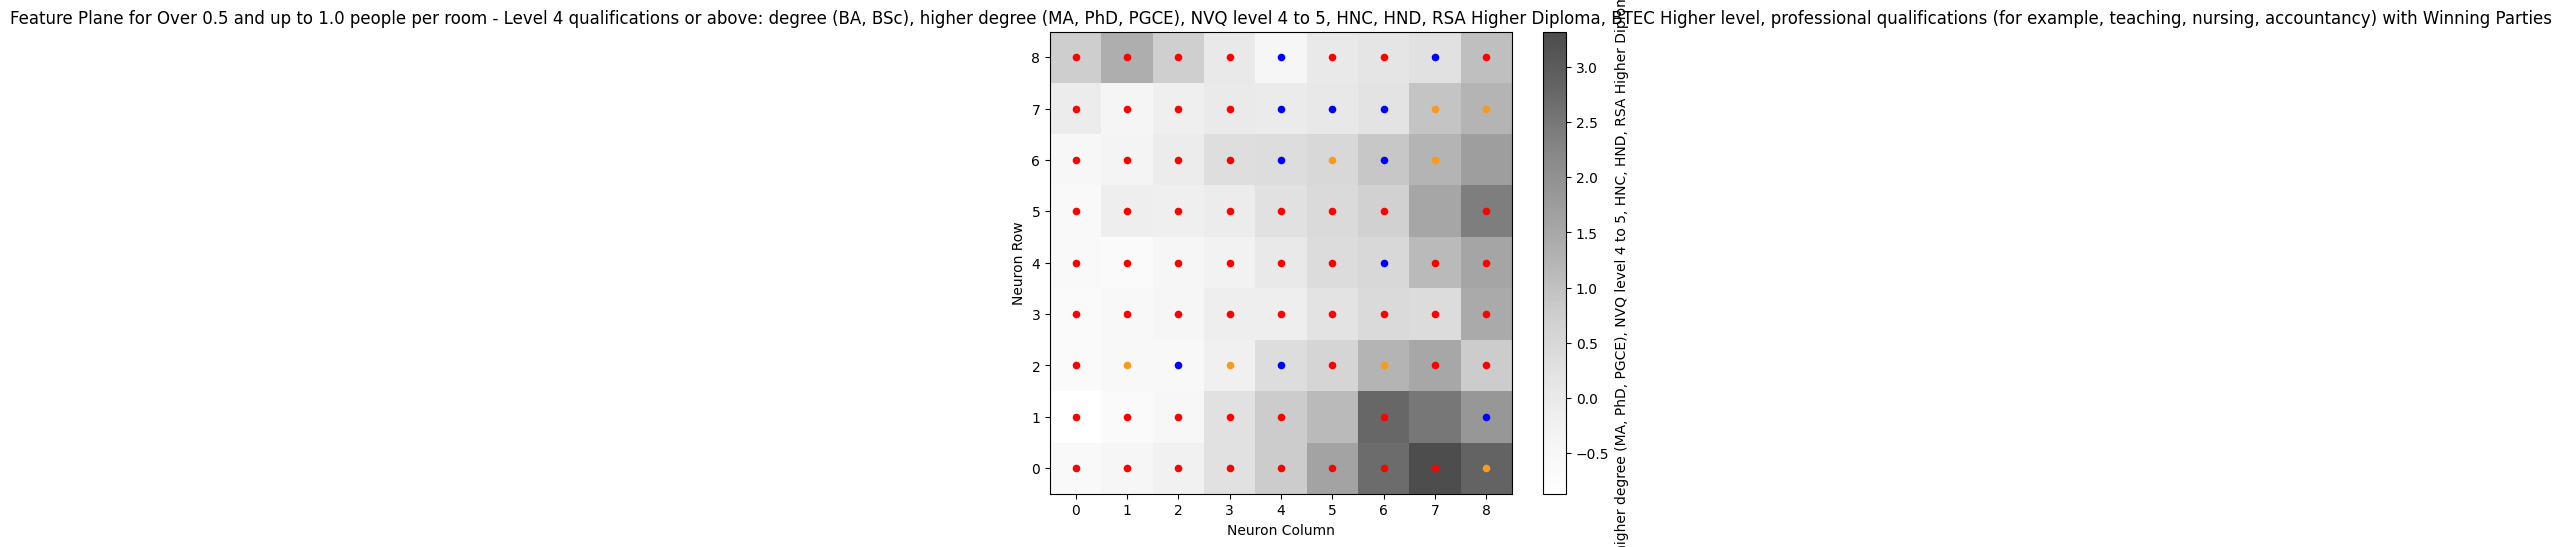

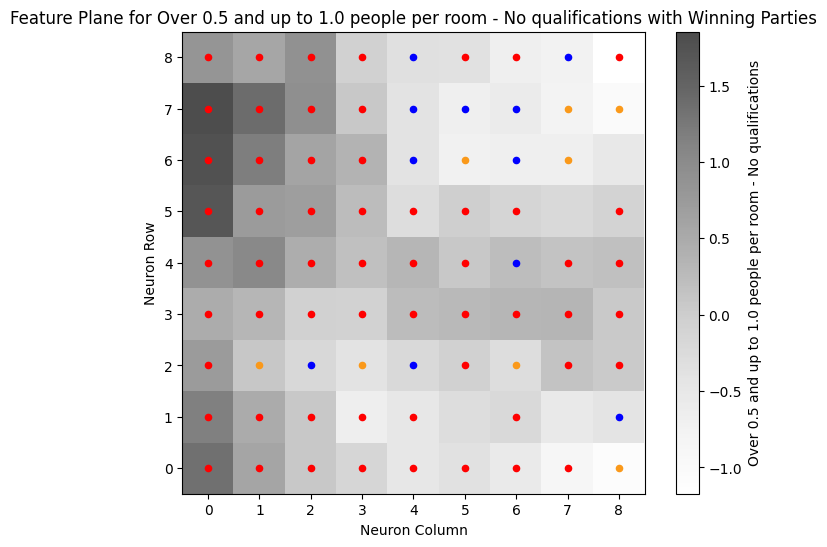

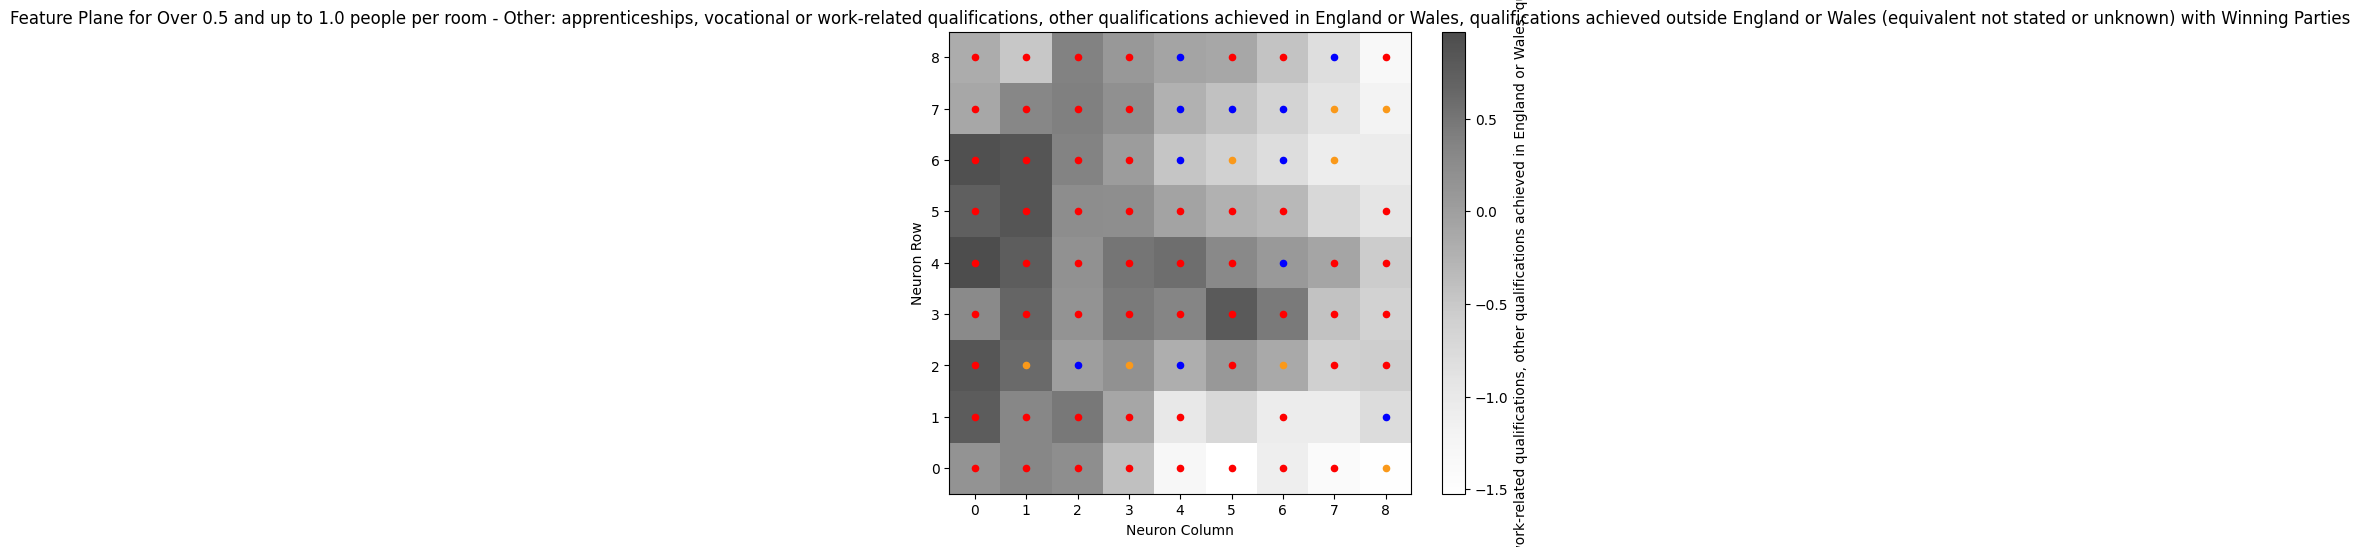

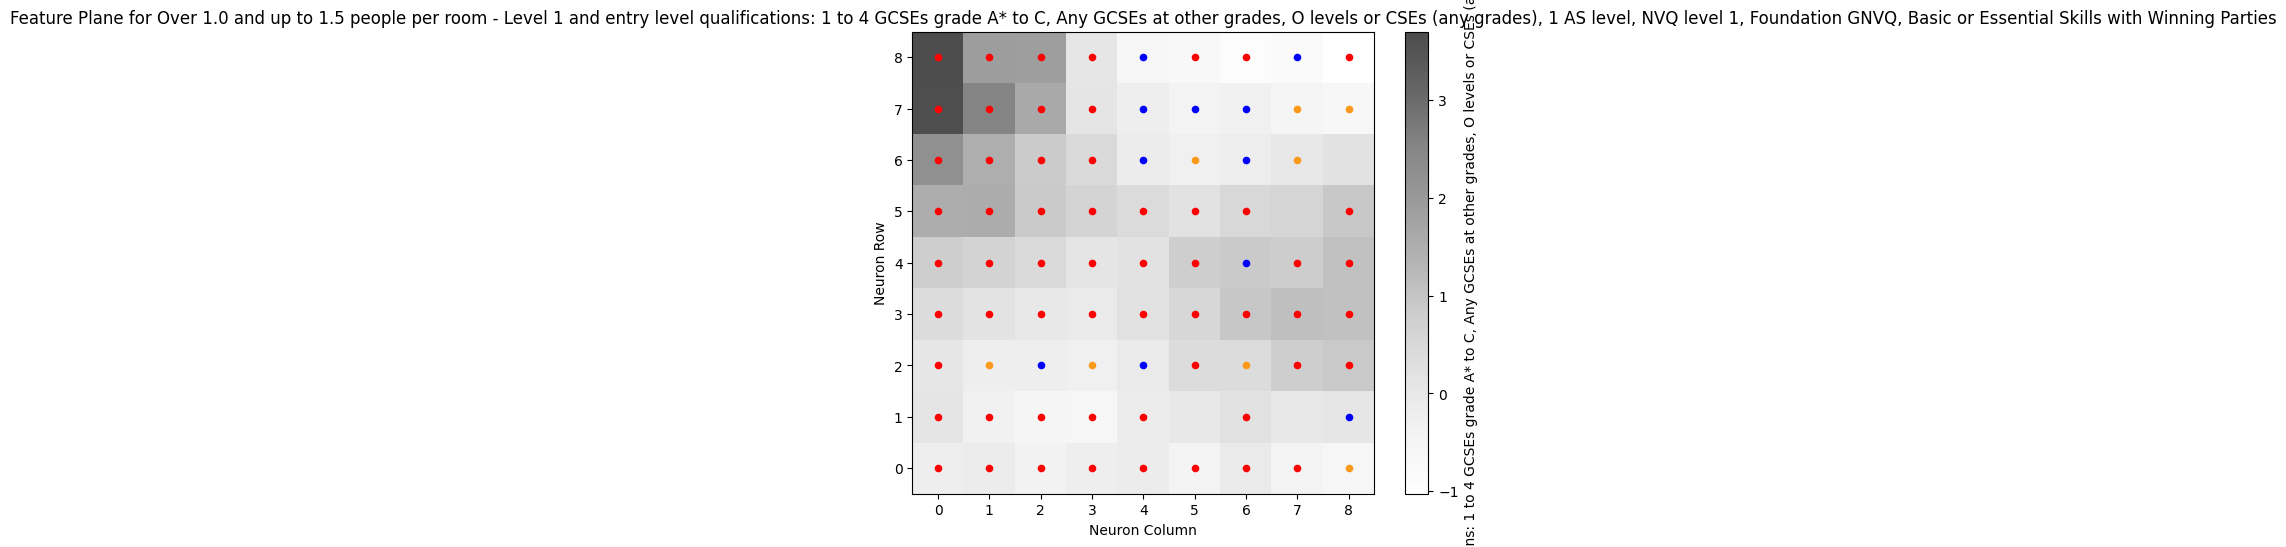

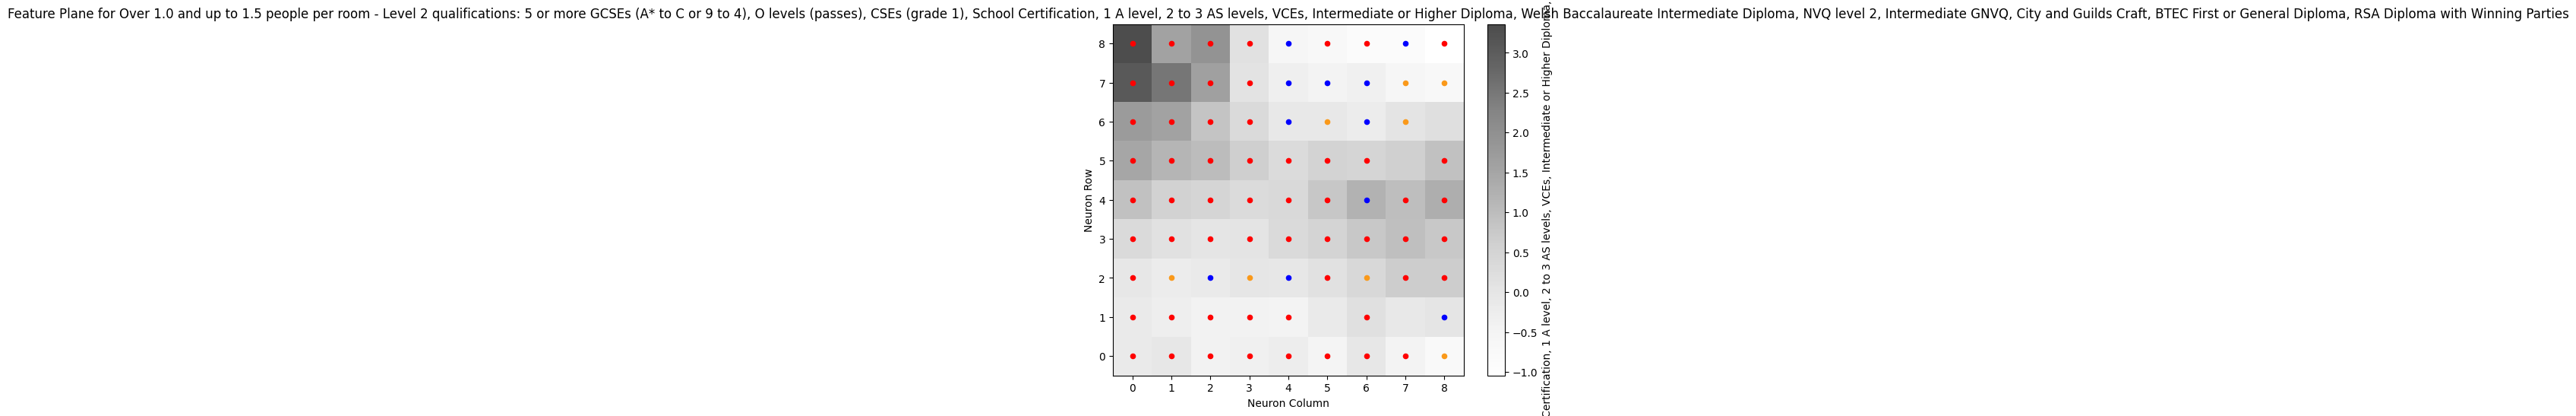

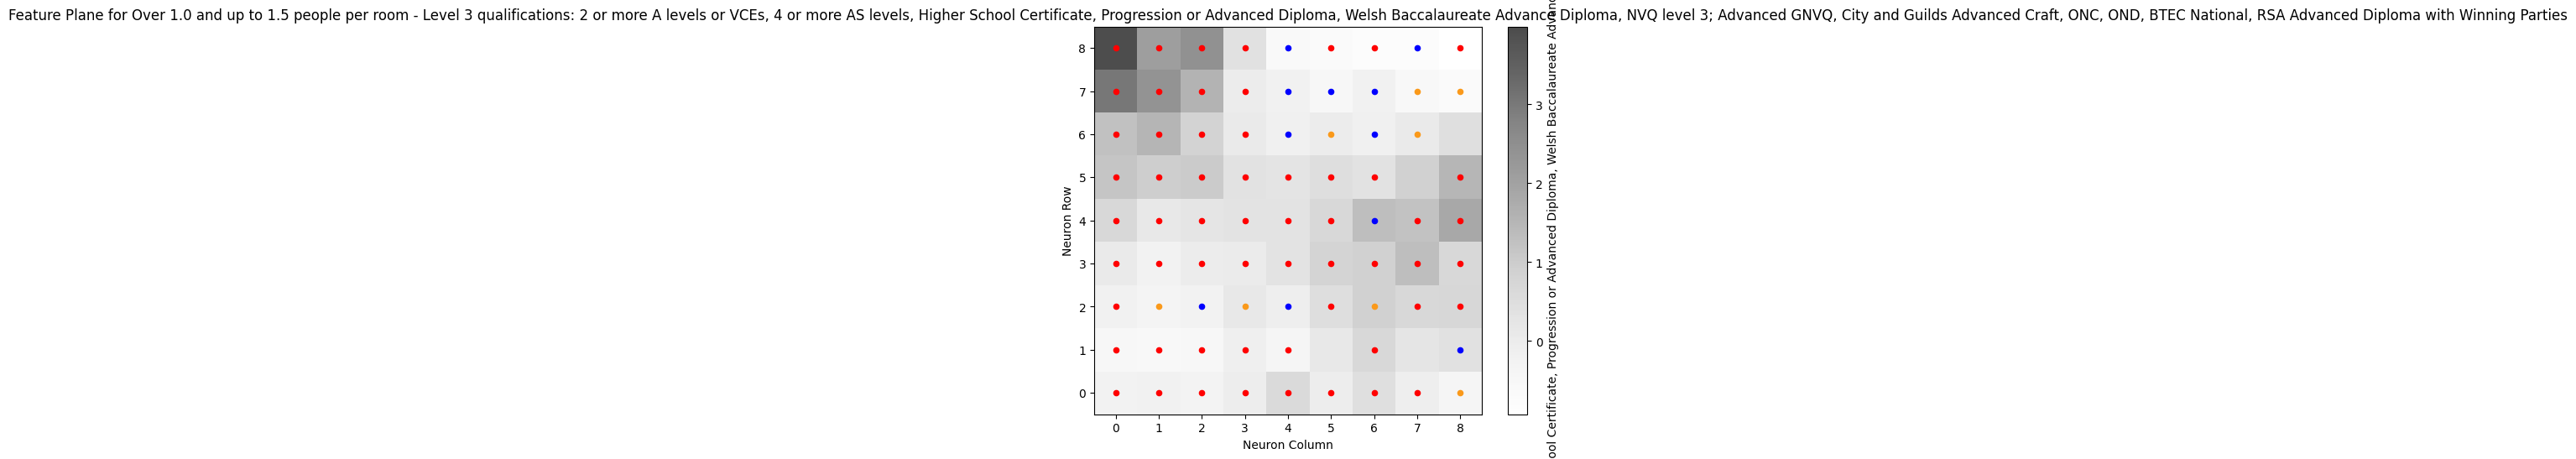

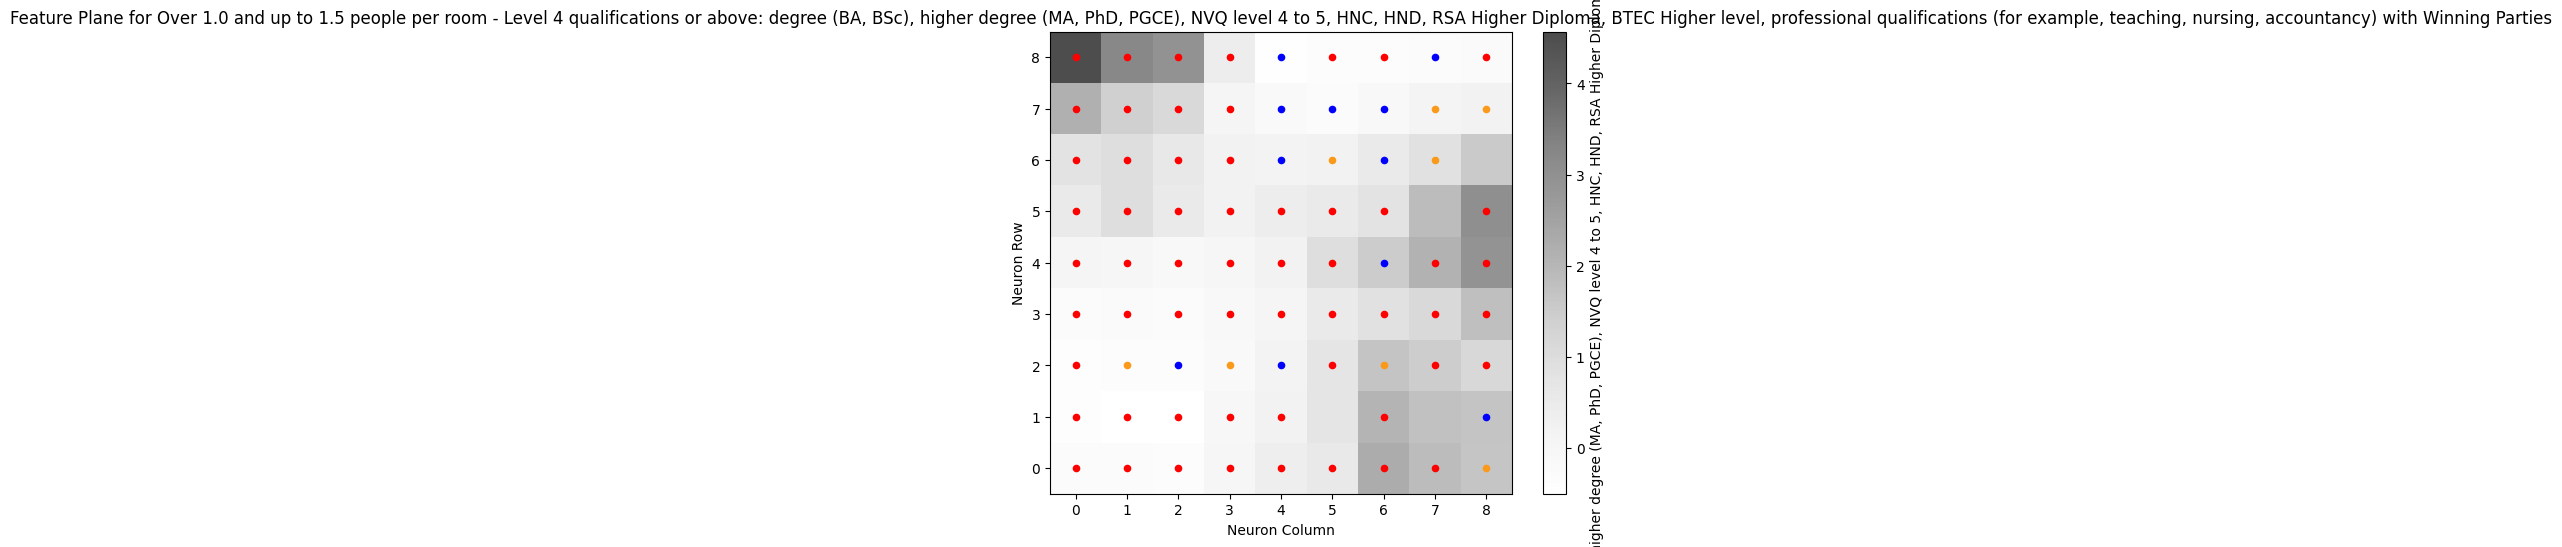

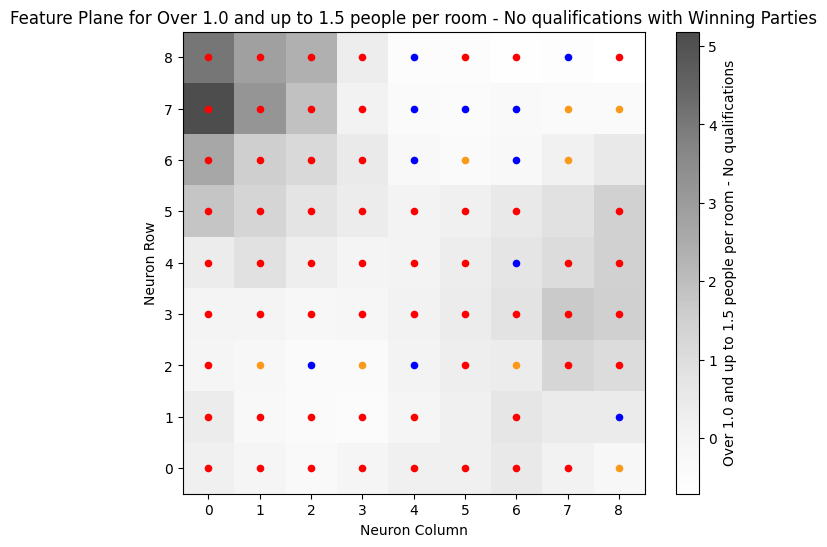

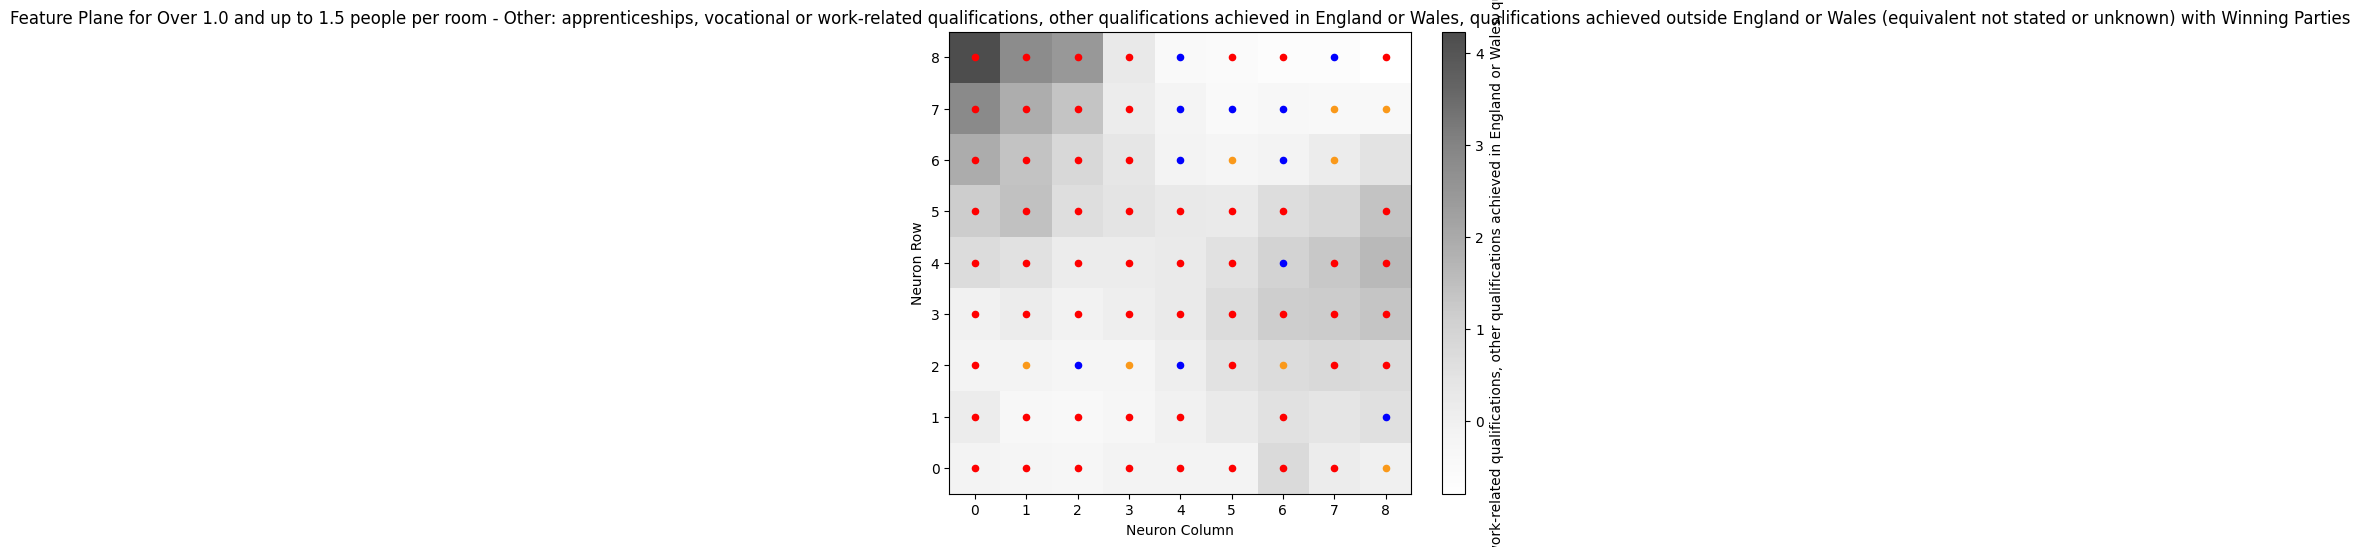

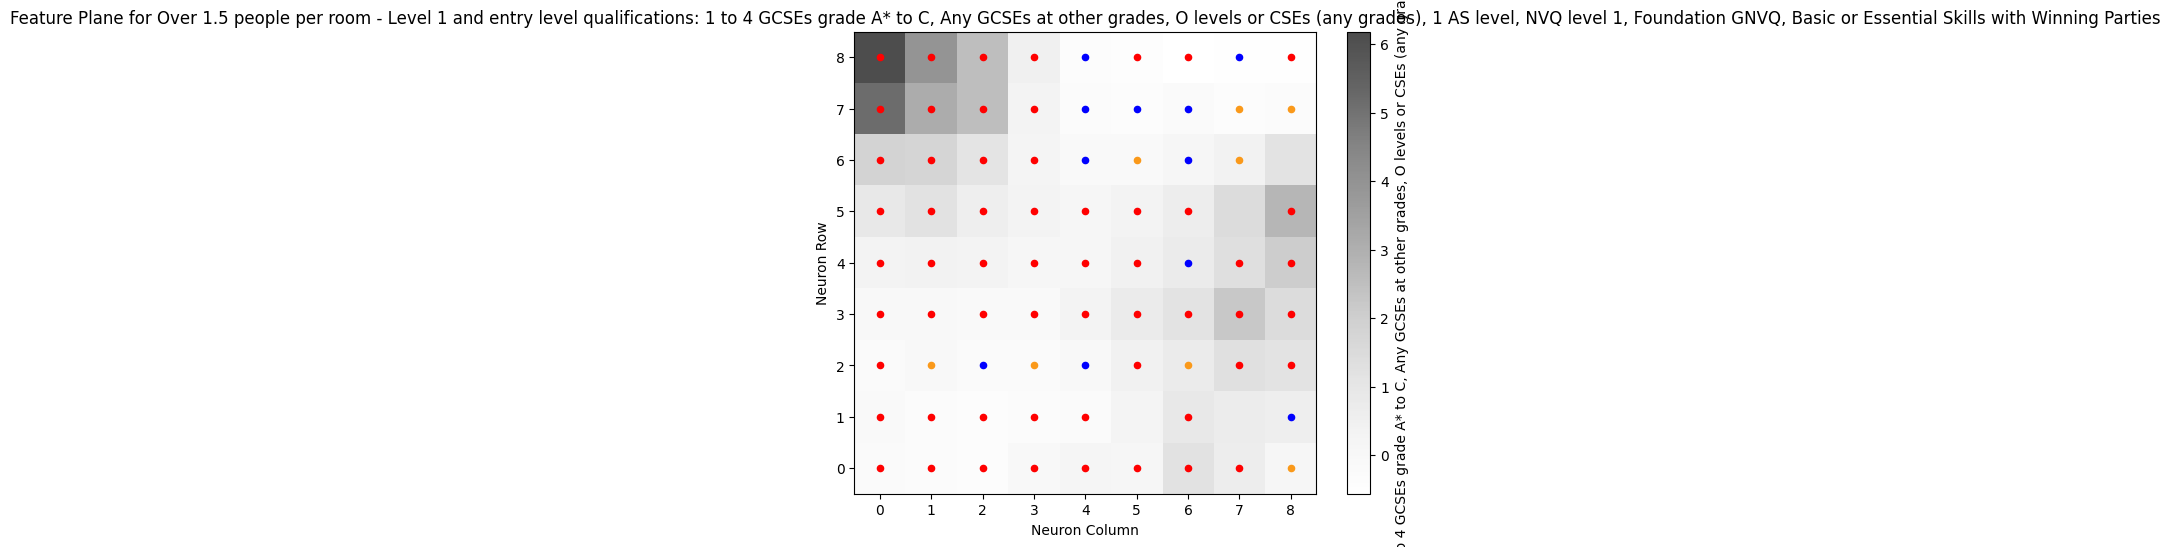

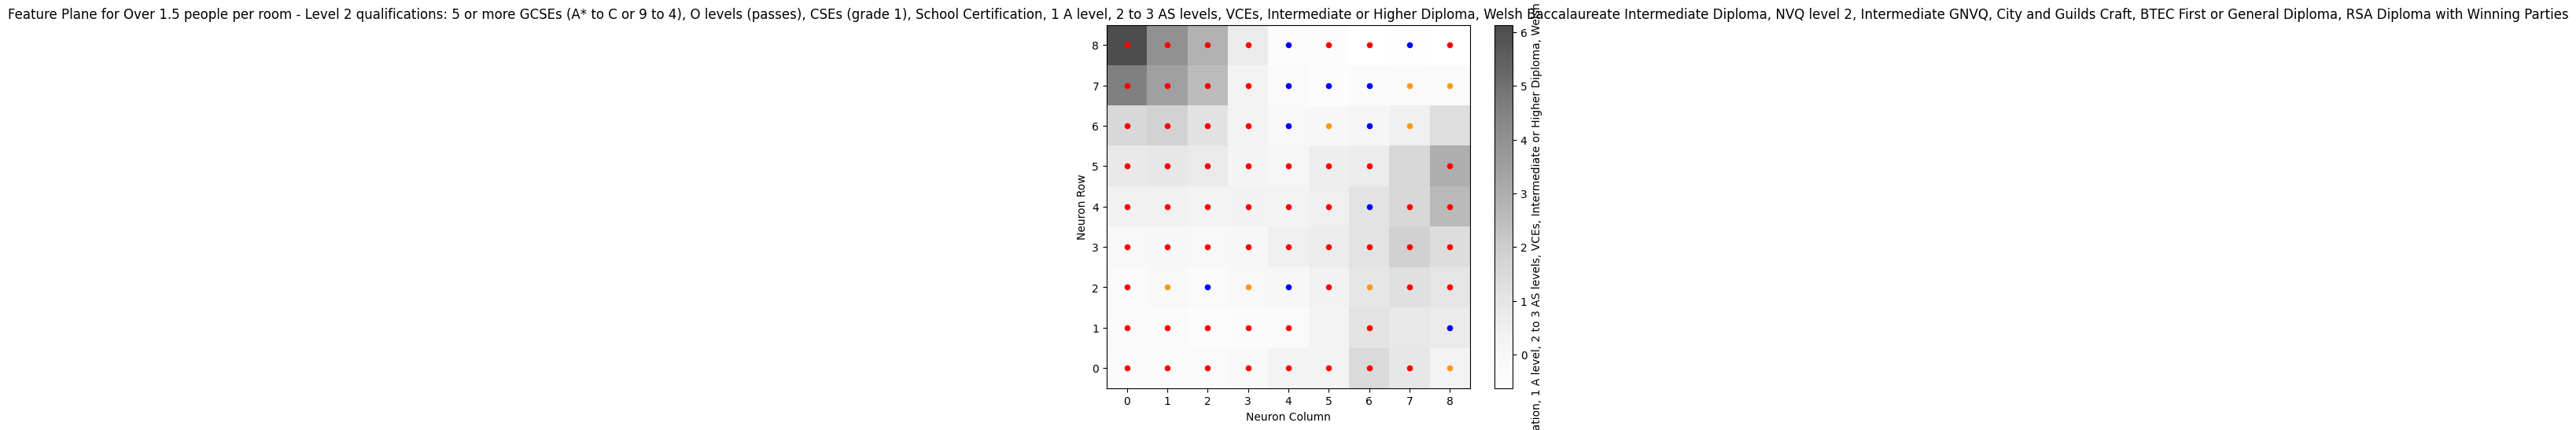

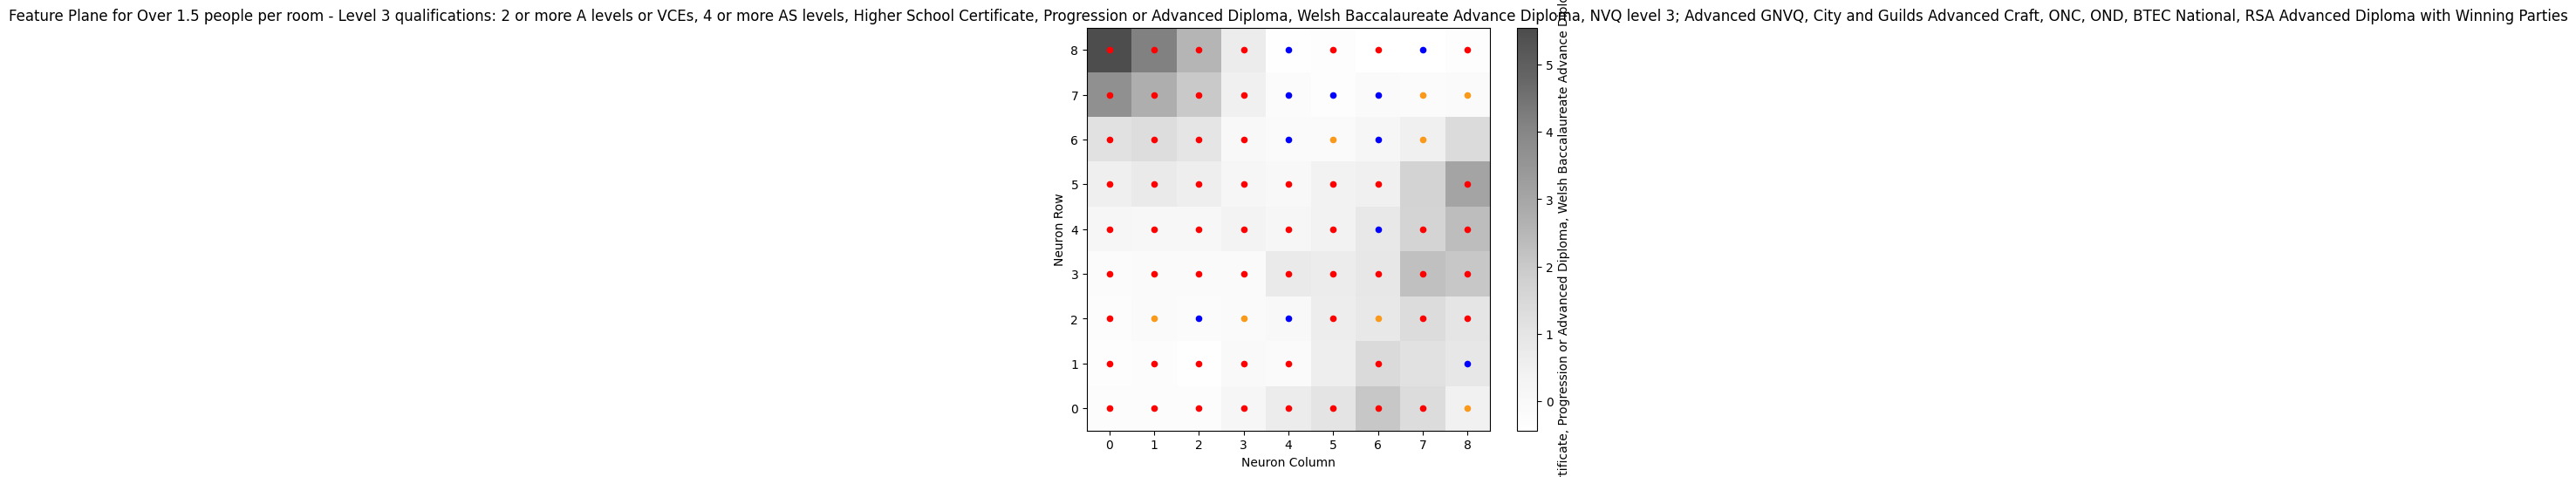

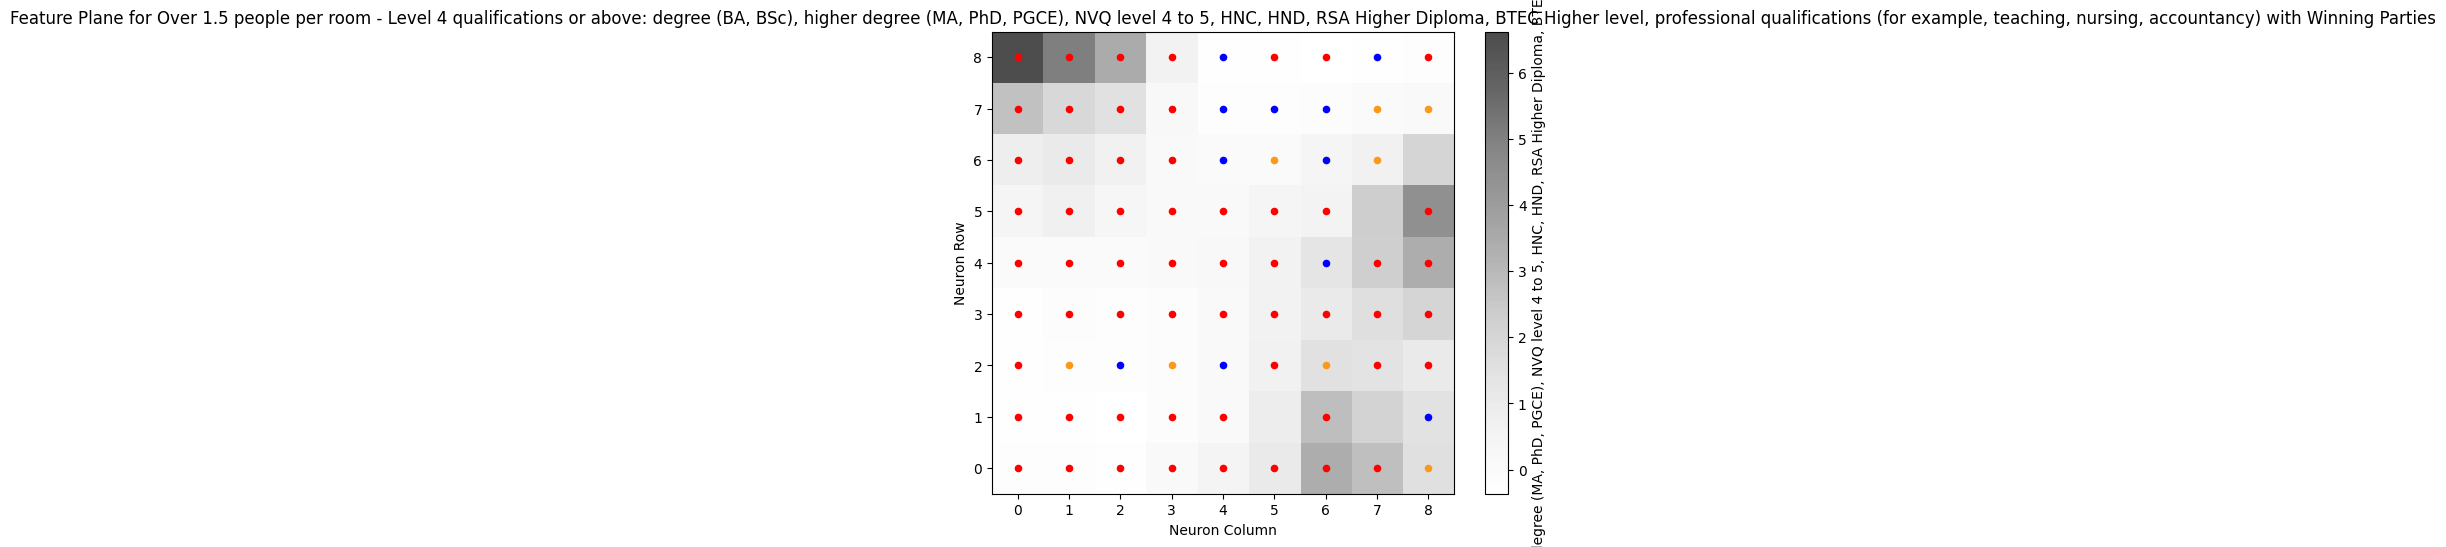

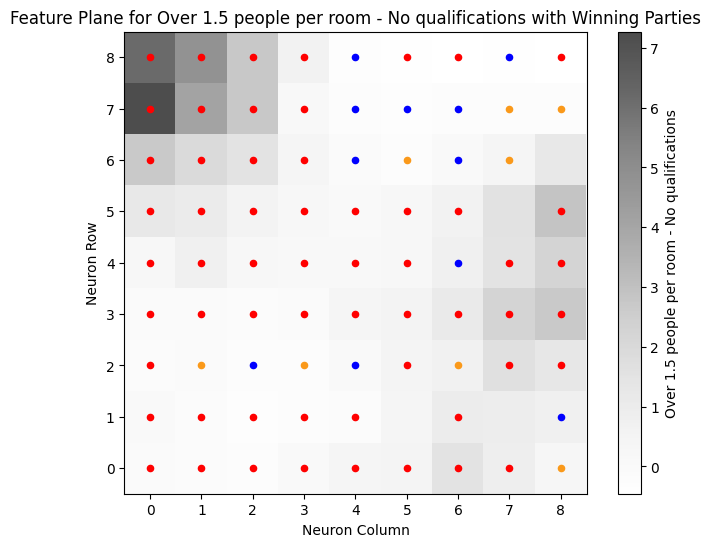

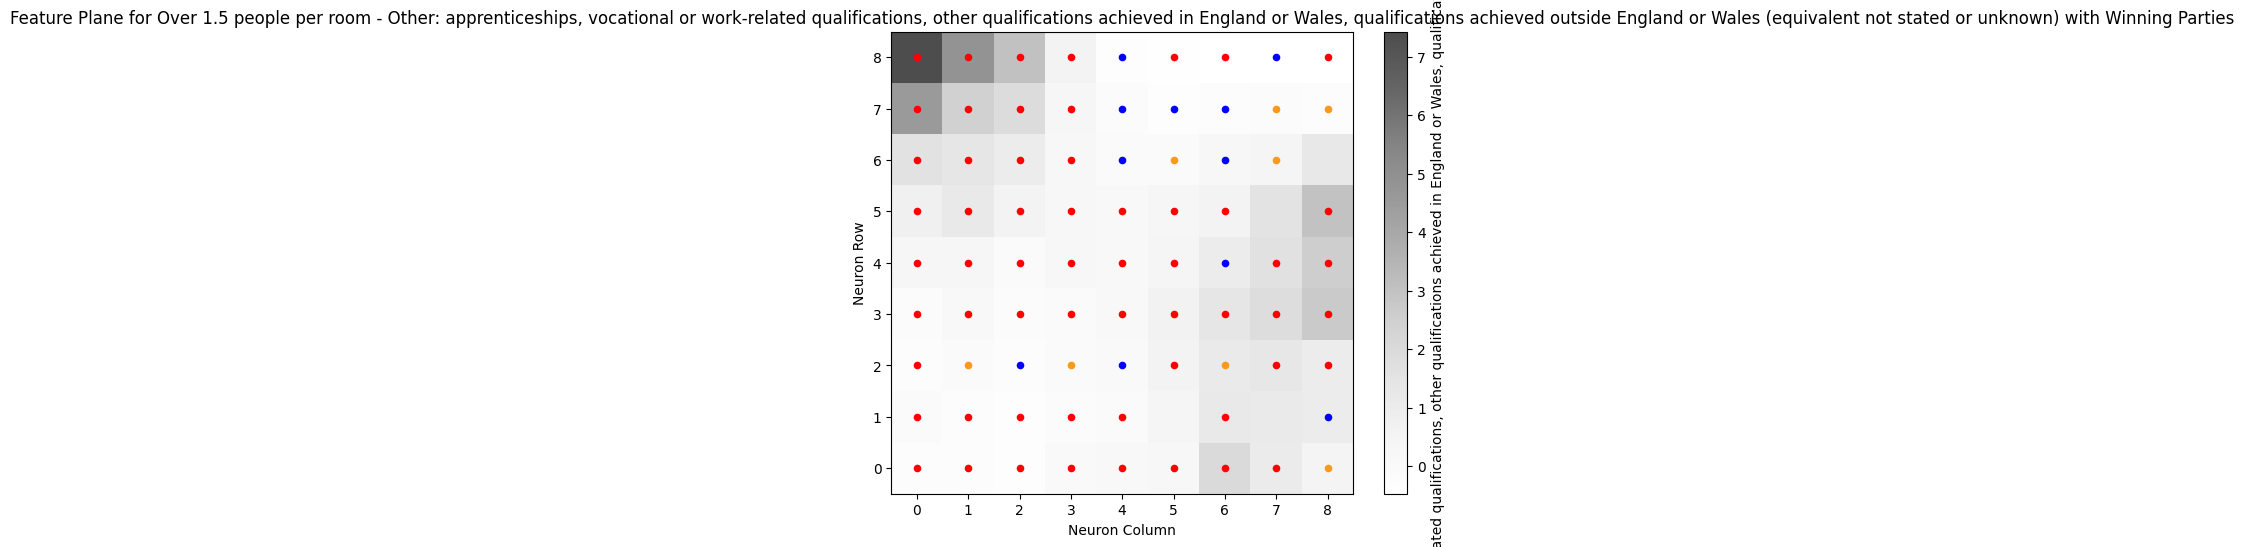

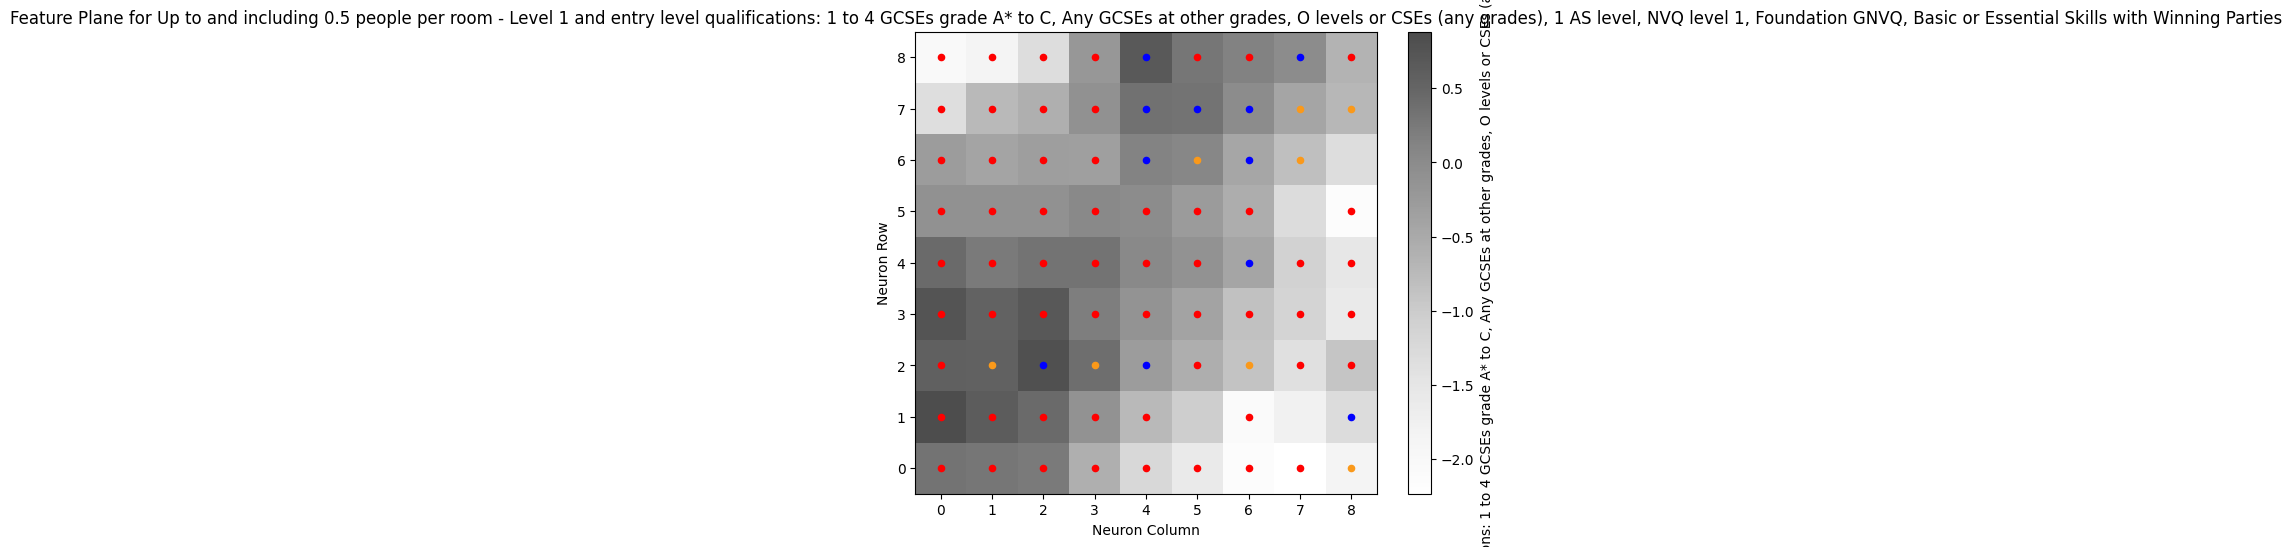

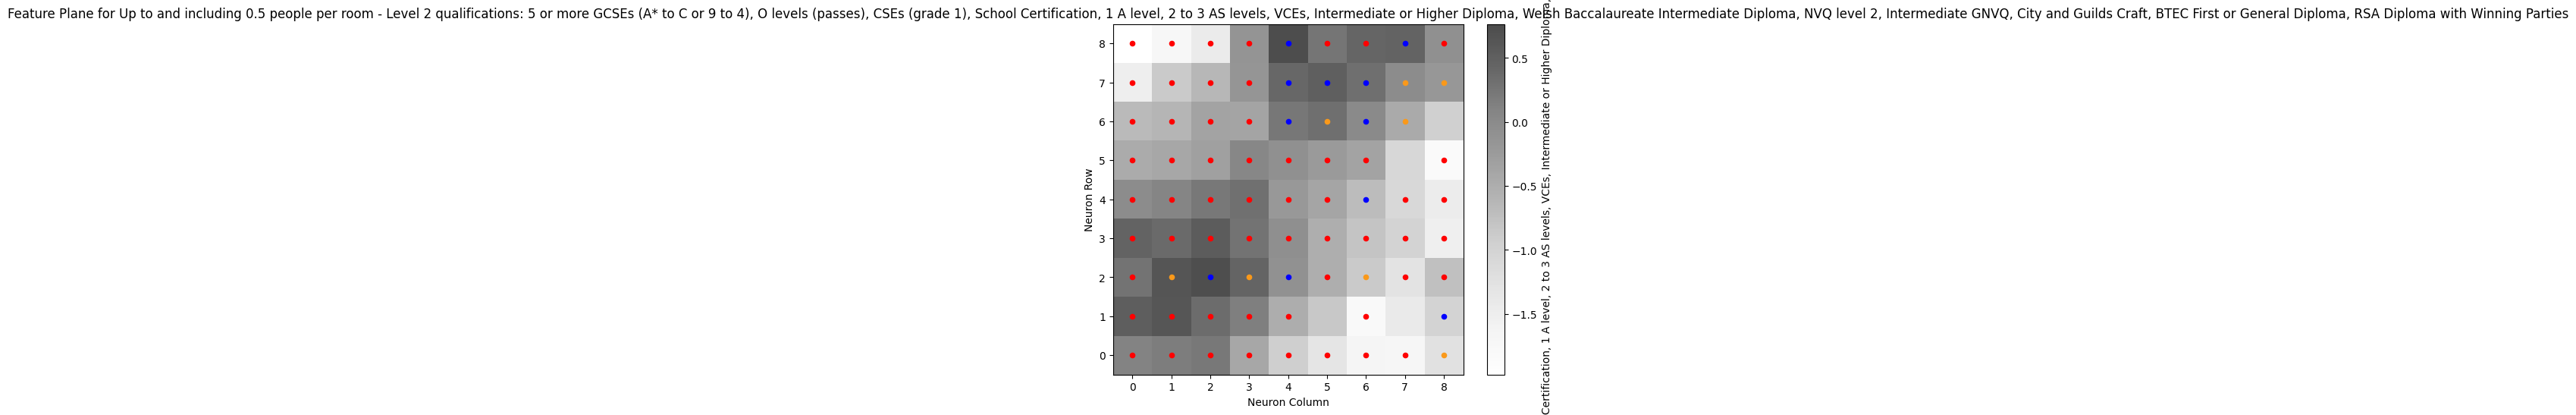

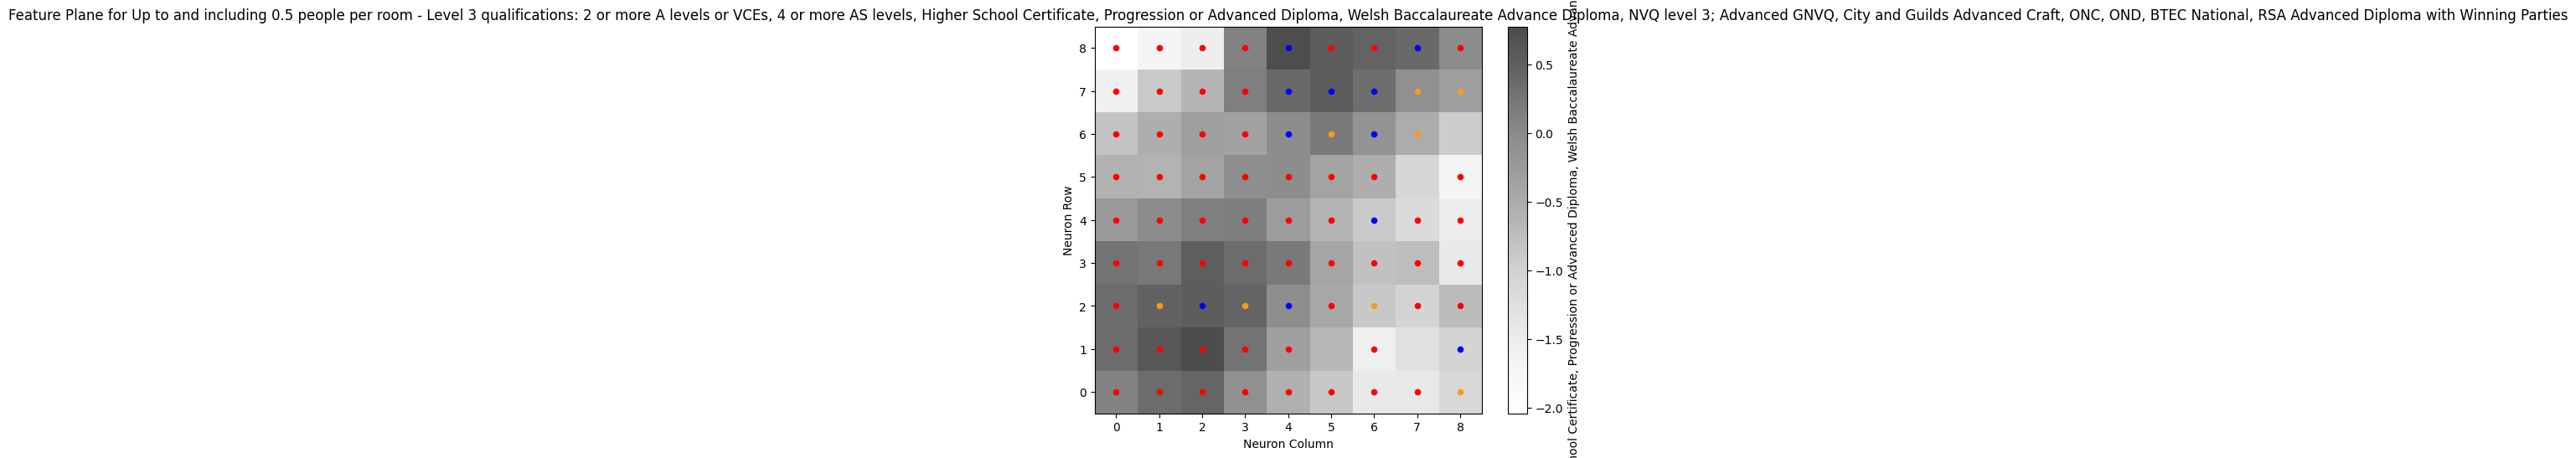

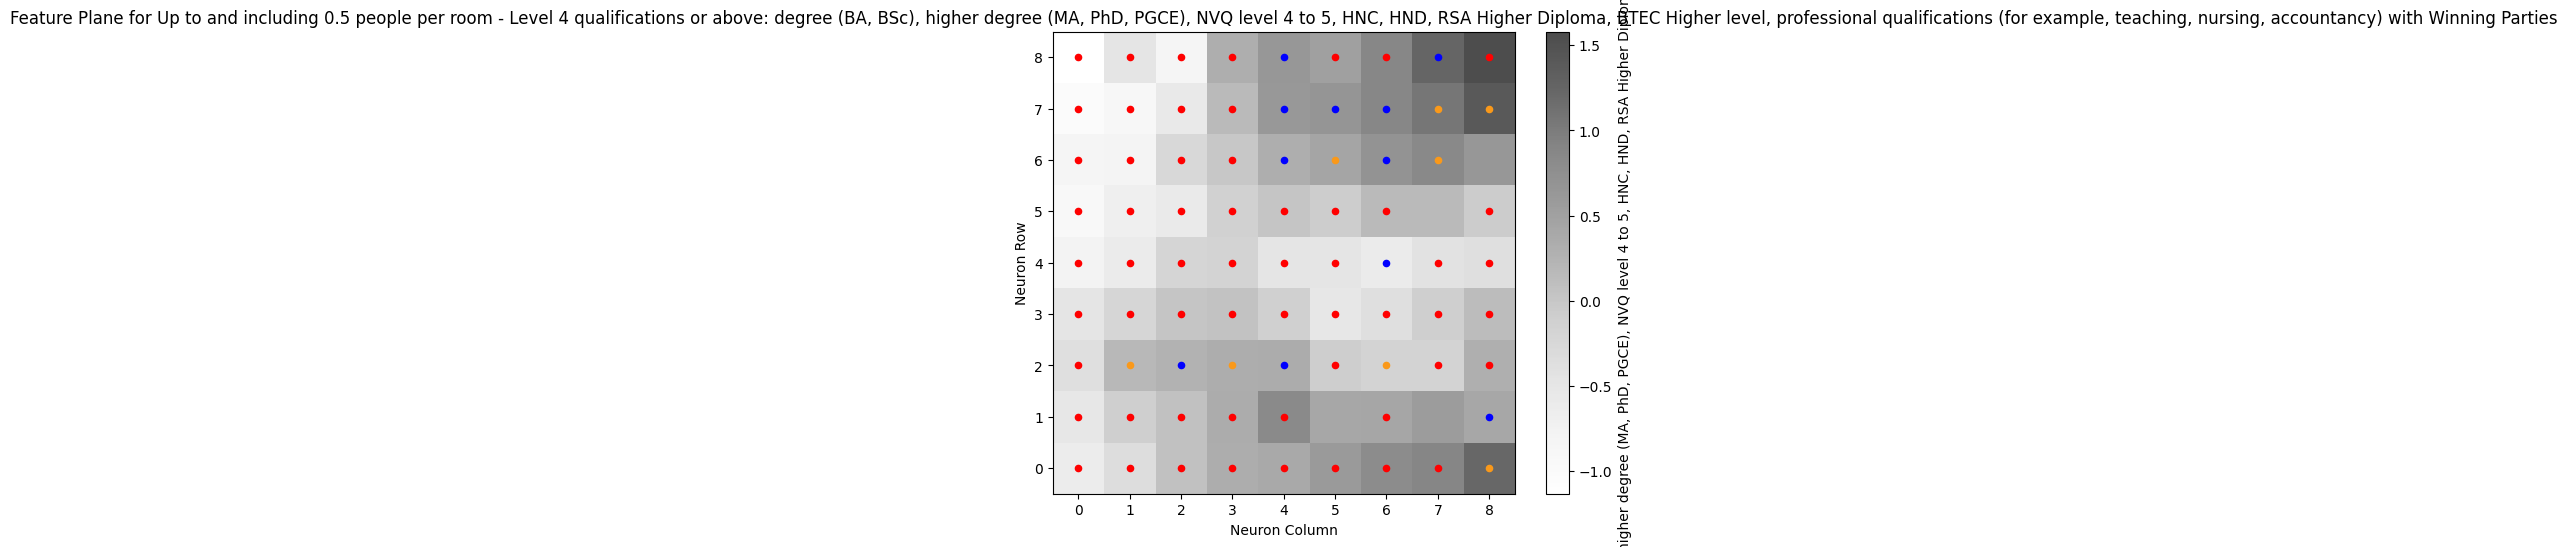

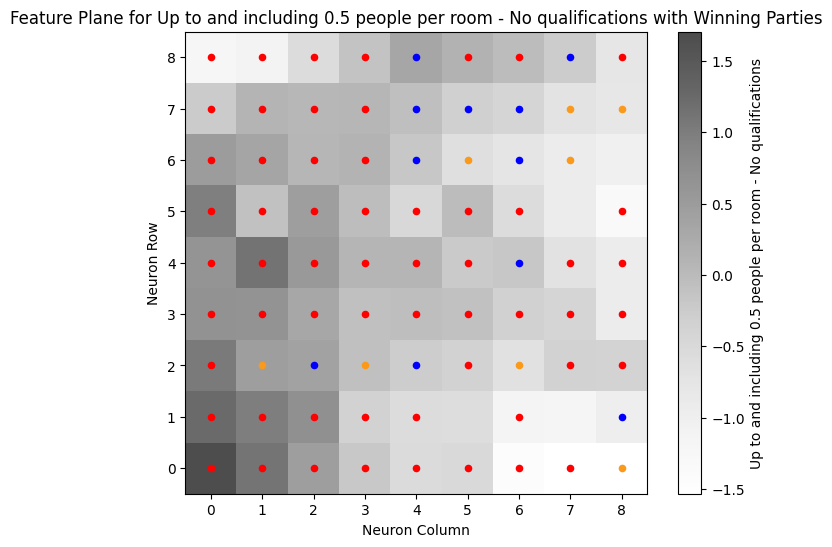

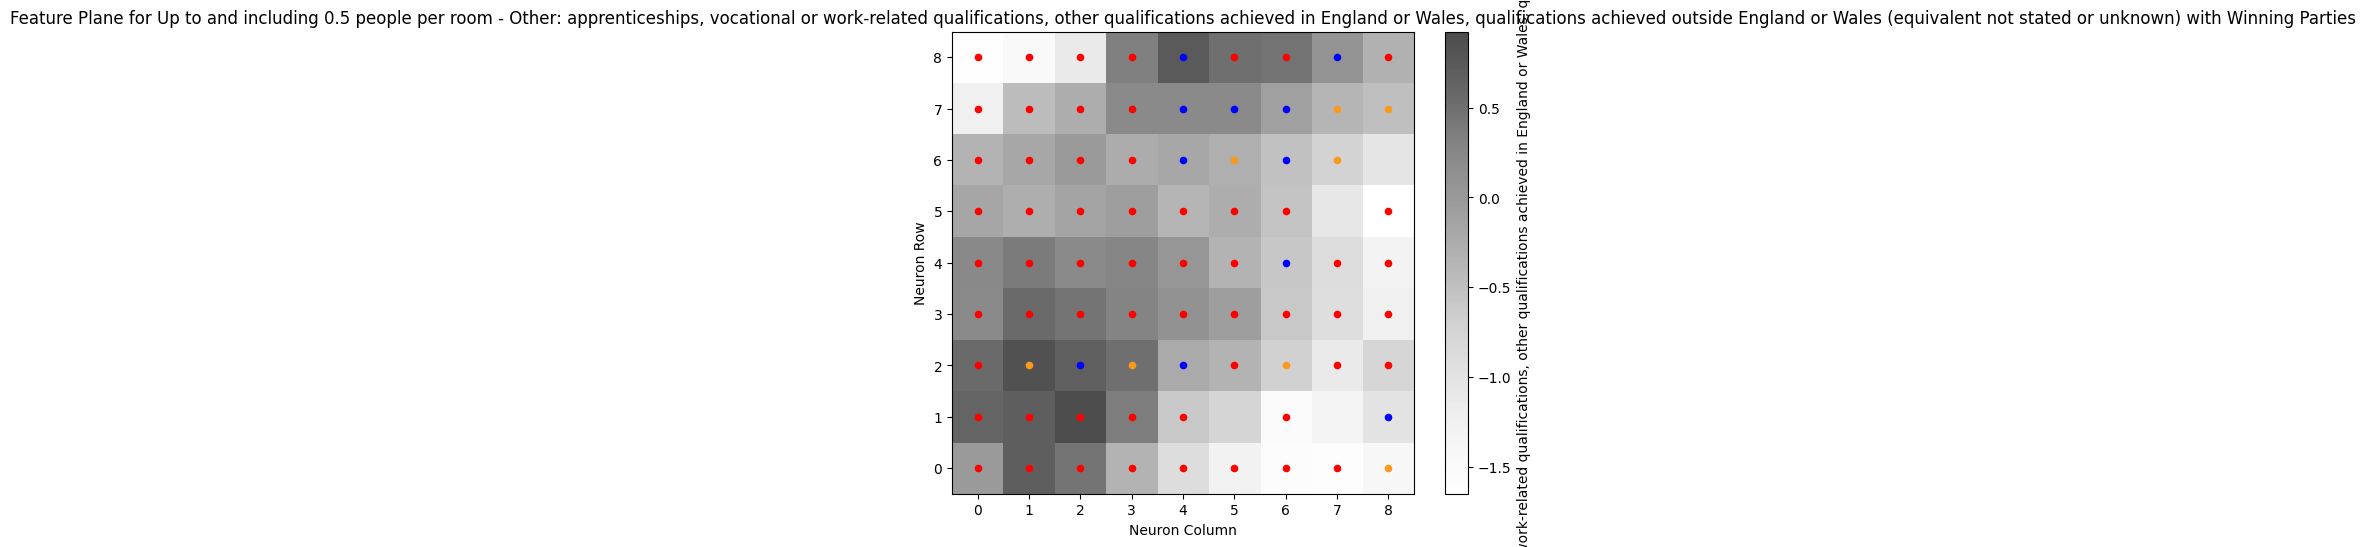

Neuron (5, 1): ['aldershot', 'crawley', 'gravesham', 'harlow', 'northampton north', 'northampton south']
Neuron (0, 1): ['aldridgebrownhills', 'hartlepool', 'makerfield', 'redcar', 'south shields', 'st helens north', 'st helens south and whiston', 'stockton north', 'sunderland central']
Neuron (7, 8): ['altrincham and sale west', 'chesham and amersham', 'esher and walton', 'oxford west and abingdon', 'south cambridgeshire']
Neuron (2, 0): ['amber valley', 'bolsover', 'erewash', 'houghton and sunderland south', 'west suffolk']
Neuron (7, 5): ['arundel and south downs', 'chippenham', 'mid bedfordshire', 'south northamptonshire', 'stroud', 'tewkesbury', 'thornbury and yate', 'warrington south']
Neuron (5, 3): ['ashford']
Neuron (6, 1): ['ashtonunderlyne', 'burnley', 'hyndburn', 'preston', 'thurrock']
Neuron (5, 6): ['aylesbury', 'bristol north west', 'hertsmere', 'milton keynes north']
Neuron (6, 3): ['banbury', 'bristol south', 'sheffield heeley', 'stockport', 'wythenshawe and sale east'

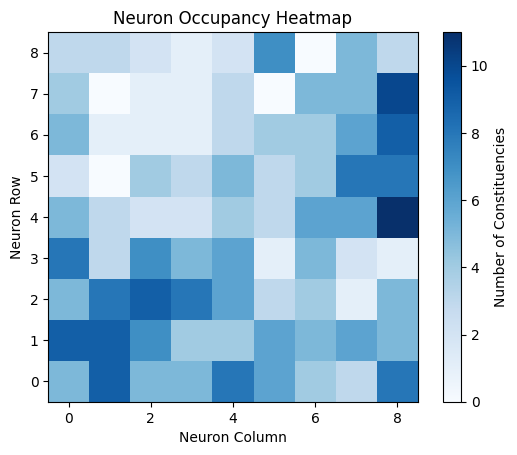

In [16]:
#U*-Matrix plotting implementation(Combination of a density matrix and distance matrix)
from scipy.ndimage import median_filter

u_matrix = som.distance_map()# this is the distance matrix
# This process was emulated from a cited paper within the report of the u*-matrix
#plotting the two dimensional grid
density_matrix = np.zeros((n_neurons, m_neurons))

for r, c in zip(normalized_df['Neuron Row'], normalized_df['Neuron Col']):
    density_matrix[r, c] += 1  # Count occurrences

# Normalize density values to avoid division errors
density_matrix = median_filter(density_matrix, size=3)

# Step 3: Compute the U*-Matrix
min_p = np.min(density_matrix)
mean_p = np.mean(density_matrix)

if mean_p - min_p == 0:
    scale_factor = np.ones_like(density_matrix)
else:
    scale_factor = (density_matrix - min_p) / (mean_p - min_p)
u_star_matrix = u_matrix * scale_factor


party_counts = (normalized_df
                .groupby(['Neuron Row', 'Neuron Col', 'Winning Party'])
                .size()
                .unstack(fill_value=0))

dominant = party_counts.idxmax(axis=1)
share    = party_counts.max(axis=1) / party_counts.sum(1)

labels_df = pd.concat([dominant.rename('major_party'),
                       share.rename('purity')], axis=1)
labels_df.to_csv('NeuronPurity.csv')



#plotting the two dimensional grid
plt.figure(figsize=(16, 12))
plt.title("U*-Matrix with Overlaid Winning Parties")
plt.imshow(u_star_matrix.T, cmap='coolwarm', origin='lower', vmin=0, vmax=1)
plt.colorbar(label="Neuron Distance (U*-Matrix)")

# Overlayying the winning parties on the grid
for (r, c), party in dominant.items():

    if party in party_colors:
        base_color = np.array(party_colors[party])
        plt.scatter(c,
                    r,
                    s=200*share.loc[(r,c)],
                    color= base_color,
                    alpha=0.7, edgecolors='k',)


# Add legend
legend_elements = [Line2D([0], [0], color=color, label=party, markersize=10)
                   for party, color in party_colors.items()]
plt.legend(handles=legend_elements, loc='upper right', title="Winning Parties")
plt.xlabel("Neuron Column")
plt.ylabel("Neuron Row")
plt.show()


#The feature planes plotted so as to see how each constituency votes based on the feature category
for feature_name in features.columns:
    feature_index = features.columns.get_loc(feature_name)
    feature_plane = som.get_weights()[:, :, feature_index]

    plt.figure(figsize=(8, 6))
    plt.imshow(feature_plane, cmap='Greys', origin='lower', alpha=0.7)
    plt.colorbar(label=feature_name)
    plt.title(f"Feature Plane for {feature_name} with Winning Parties")
    plt.xlabel("Neuron Column")
    plt.ylabel("Neuron Row")

    # for index, row in normalized_df.iterrows():
    for (r, c), party in dominant.items():

        colour = np.array(party_colors[party])
        if party in party_colors:
          plt.scatter(c, r, color=colour, marker='o', s=20)

    plt.show()


# Neuron-Constituency Mapping for cluster analysis and understanding
neuron_constituency_map = {}
for index, row in normalized_df.iterrows():
    neuron = (row['Neuron Row'], row['Neuron Col'])
    constituency = row['Westminster Parliamentary constituencies']
    if neuron not in neuron_constituency_map:
        neuron_constituency_map[neuron] = []
    neuron_constituency_map[neuron].append(constituency)


# Print the constituencies mapped to each neuron
for neuron, constituencies in neuron_constituency_map.items():
    print(f"Neuron {neuron}: {constituencies}")





normalized_df['Neuron'] = list(zip(normalized_df['Neuron Row'], normalized_df['Neuron Col']))


# Party Distribution of the winning neurons with its vote share dataset for analysis
grouped = normalized_df.groupby("Neuron").agg({
    'Winning Party': lambda x: x.value_counts().to_dict(),
    'Winning Vote Share': 'mean',
}).rename(columns={
    'Winning Party': 'Party Distribution',
    'Winning Vote Share': 'Avg Vote Share',
})

print(grouped.head())

grouped.to_csv('neuron_party_distribution.csv')

from matplotlib import pyplot as plt

hit_map = np.zeros((som._weights.shape[0], som._weights.shape[1]))
for x in normalized_features:
    bmu = som.winner(x)
    hit_map[bmu] += 1

plt.imshow(hit_map.T, cmap='Blues', origin='lower')
plt.colorbar(label='Number of Constituencies')
plt.title('Neuron Occupancy Heatmap')
plt.xlabel('Neuron Column')
plt.ylabel('Neuron Row')
plt.show()



In [13]:
#Clusters identified
valley_cells = {(8,2),(7,2),(7,3),(6,2),(6,1)}

valley_df = normalized_df[
    normalized_df.apply(
        lambda r: (r['Neuron Row'], r['Neuron Col']) in valley_cells,
        axis=1
    )
][[
    'Westminster Parliamentary constituencies',
    'Winning Party',
    'Winning Vote Share'
]]

valley_df.to_csv("valley_constituencies.csv", index=False)
display(valley_df.head())

,Westminster Parliamentary constituencies,Winning Party,Winning Vote Share
6,ashtonunderlyne,Labour,0.439215
17,bedford,Labour,0.451118
33,bolton north east,Labour,0.372841
34,bolton west,Labour,0.389322
51,burnley,Labour,0.317178


In [14]:
seat_counts  = valley_df['Winning Party'].value_counts()
purity       = seat_counts.max() / seat_counts.sum()

print("Seats by party:\n", seat_counts)
print(f"Purity = {purity:.1%}")


Seats by party:
 Winning Party
Labour    17
Name: count, dtype: int64
Purity = 100.0%


In [15]:
feature_cols = features.columns #the features in the dataset
valley_features = normalized_df.loc[valley_df.index, feature_cols]

# mean of the observations  education level inside the valley
valley_profile = valley_features.mean()

print(valley_features)
print(valley_profile)

     Over 0.5 and up to 1.0 people per room - Level 1 and entry level qualifications: 1 to 4 GCSEs grade A* to C, Any GCSEs at other grades, O levels or CSEs (any grades), 1 AS level, NVQ level 1, Foundation GNVQ, Basic or Essential Skills  \
6                                             0.824102                                                                                                                                                                                            
17                                            0.739785                                                                                                                                                                                            
33                                            0.174075                                                                                                                                                                                            
34                          